In [1]:
# In this file 
# we train the MeasureVAE "Learning to Traverse Latent Spaces for Musical Score Inpainting", published in ISMIR 2019
# The core model code is from their releasing code.

from MeasureVAE.measure_vae import MeasureVAE
from utils.helpers import *
from utils.noise_adder import NoiseAdder
import numpy as np
from torch import optim
import random
from data_processor import DatasetProcessor
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau

data_path = [
    "data/bachinv_1.npy",
    "data/bachinv_2.npy"
]

# paramters initialization
num_notes = 86
note_embedding_dim=10
metadata_embedding_dim=2
num_encoder_layers=2
encoder_hidden_size=512
encoder_dropout_prob=0.5
has_metadata=False
latent_space_dim = 512
num_decoder_layers=2
decoder_hidden_size=512
decoder_dropout_prob=0.5
batch_size=128
num_epochs=50
train=True
plot=False
log=True
lr=1e-4
seq_len = 8 * 6
n_epochs = 50
save_period = 5
ratio = [1.0,0.0,0]


In [2]:
# set random
torch.manual_seed(1028)
random.seed(1028)
np.random.seed(1028)

In [3]:
# import data

trainset = []
for dpath in data_path:
    dp = DatasetProcessor(data = dpath)
    dp.split(ratio[::])
    trainset += dp.process(dataset = dp.trainset, vae = "MeasureVAE", spb = 48, bar_num = 1 , shift_note = [0])
trainset = torch.from_numpy(np.array(trainset)).long()
print(trainset.size())

data/invent11.mid process ok: 100%|██████████| 14/14 [00:00<00:00, 353.06it/s]

dataset size: 14
train:14 	 validate:0 	 test:0
total len:742
error files:0
[]
dataset size: 14
train:14 	 validate:0 	 test:0
total len:743
error files:0
[]
torch.Size([1485, 48])


In [4]:
trainset = TensorDataset(trainset)
train_loader = DataLoader(dataset = trainset, batch_size = batch_size, shuffle = False)

In [5]:
# loss function
def compute_kld_loss(z_dist, prior_dist, beta=0.001):
    """

    :param z_dist: torch.nn.distributions object
    :param prior_dist: torch.nn.distributions
    :param beta:
    :return: kl divergence loss
    """
    kld = torch.distributions.kl.kl_divergence(z_dist, prior_dist)
    kld = beta * kld.sum(1).mean()
    return kld

def mean_crossentropy_loss(weights, targets):
    """
    Evaluates the cross entropy loss
    :param weights: torch Variable,
            (batch_size, seq_len, num_notes)
    :param targets: torch Variable,
            (batch_size, seq_len)
    :return: float, loss
    """
    criteria = torch.nn.CrossEntropyLoss(reduction='mean')
    batch_size, seq_len, num_notes = weights.size()
    weights = weights.contiguous().view(-1, num_notes)
    targets = targets.contiguous().view(-1)
    loss = criteria(weights, targets)
    return loss

def mean_accuracy(weights, targets):
    """
    Evaluates the mean accuracy in prediction
    :param weights: torch Variable,
            (batch_size, seq_len, num_notes)
    :param targets: torch Variable,
            (batch_size, seq_len)
    :return float, accuracy
    """
    _, _, num_notes = weights.size()
    weights = weights.contiguous().view(-1, num_notes)
    targets = targets.contiguous().view(-1)

    _, max_indices = weights.max(1)
    correct = max_indices == targets
    return torch.sum(correct.float()) / targets.size(0)



In [6]:
# import measureVAE
save_path = "model_backup/"
model = MeasureVAE(
    num_notes = num_notes,
    note_embedding_dim=note_embedding_dim,
    metadata_embedding_dim=metadata_embedding_dim,
    num_encoder_layers=num_encoder_layers,
    encoder_hidden_size=encoder_hidden_size,
    encoder_dropout_prob=encoder_dropout_prob,
    latent_space_dim=latent_space_dim,
    num_decoder_layers=num_decoder_layers,
    decoder_hidden_size=decoder_hidden_size,
    decoder_dropout_prob=decoder_dropout_prob,
    has_metadata=has_metadata
)

dic = torch.load("model_backup/measurevae_saved.pt")

for name in list(dic.keys()):
    dic[name.replace('module.', '')] = dic.pop(name)
model.load_state_dict(dic)

optimizer = optim.Adam(model.parameters(), lr = lr)
if torch.cuda.is_available():
    print('Using: ', torch.cuda.get_device_name(torch.cuda.current_device()))
    model.cuda()
else:
    print('Using: CPU')



NUMBER OF NOTES:  86
embedding: 10
Using:  GeForce RTX 2080 Ti


In [7]:
# output reconstruction 
v_recon = np.array([])
z_sample = []
z_mean = []
z_var = [] # std deviation!! not variance
z_gd = []
for i,data in enumerate(train_loader):
    print(i)
    model.eval()
    v_x = data[0]
    v_target = v_x.view(-1)
    if torch.cuda.is_available():
        v_x = v_x.cuda()
        v_target = v_target.cuda()
    with torch.no_grad():
        v_weights, v_samples, v_z_dist, v_prior_dist, v_z_tilde, v_z_prior = model(measure_score_tensor=v_x,train=False)
        z_sample.append(v_z_tilde.detach().cpu().numpy())
        z_mean.append(v_z_dist.loc.detach().cpu().numpy())
        z_var.append(v_z_dist.scale.detach().cpu().numpy())
        z_gd.append(v_x.detach().cpu().numpy())
#         v_recons_loss = mean_crossentropy_loss(weights=v_weights, targets=v_target)
#         if len(v_recon) == 0: 
#             v_recon = torch.argmax(v_weights,-1).detach().cpu().numpy()
#             print(v_recon.shape)
#         else:
#             v_recon = np.concatenate([v_recon, torch.argmax(v_weights,-1).detach().cpu().numpy()], 0)
#             print(v_recon.shape)

0
1


/home/kechen/Research/JCMS-2021-BachInventionExp/MeasureVAE/encoder.py:115: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  if nan_check.nonzero().size(0) > 0:


2
3
4
5
6
7
8
9
10
11


In [8]:
z_sample = np.concatenate(np.array(z_sample), axis = 0)
z_mean = np.concatenate(np.array(z_mean), axis = 0)
z_var = np.concatenate(np.array(z_var), axis = 0)
z_gd = np.concatenate(np.array(z_gd), axis = 0)
print(z_sample.shape)
print(z_mean.shape)
print(z_var.shape)
print(z_gd.shape)

(1485, 512)
(1485, 512)
(1485, 512)
(1485, 48)


/home/kechen/miniconda3/envs/kechen_py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
/home/kechen/miniconda3/envs/kechen_py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/home/kechen/miniconda3/envs/kechen_py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays wi

In [15]:
# Call only once
mi_group = []

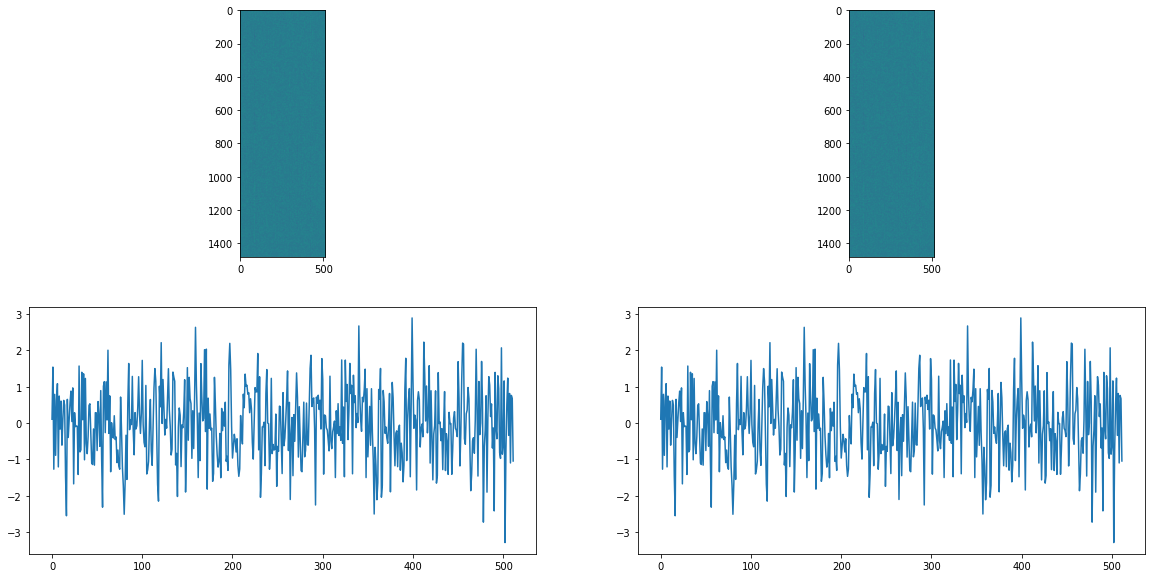

In [36]:
# Start corruption
torch.manual_seed(1028)
random.seed(1028)
np.random.seed(1028)
na = NoiseAdder(512)
z_mu, z_sigma, _, z_quant = na.get_bit_allocation(z_sample, 10000)
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.imshow(z_sample)
plt.subplot(2,2,2)
plt.imshow(z_quant)
plt.subplot(2,2,3)
plt.plot(z_sample[0])
plt.subplot(2,2,4)
plt.plot(z_quant[0])


In [37]:
from mine_model import Mine
# one voice -> another voice
x_in = z_sample[742:, :] # first
y_in = z_sample[:742,:] # second
# or 
# previous -> future
# x_in = z_quant[0:-1,:]
# y_in = z_sample[1:,:]
if len(y_in) != len(x_in):
    x_in = x_in[:len(y_in)]
y_shuffle = np.random.permutation(y_in)

x_in = Variable(torch.from_numpy(x_in).type(torch.FloatTensor), requires_grad = True)
y_in = Variable(torch.from_numpy(y_in).type(torch.FloatTensor), requires_grad = True)
y_shuffle = Variable(torch.from_numpy(y_shuffle).type(torch.FloatTensor), requires_grad = True)

# joint_data = np.concatenate((x_in, y_in), axis = 1)
# marginal_data = np.concatenate((x_in, y_shuffle), axis = 1)
# joint_data = Variable(torch.from_numpy(joint_data).type(torch.FloatTensor), requires_grad = True)
# marginal_data = Variable(torch.from_numpy(marginal_data).type(torch.FloatTensor), requires_grad = True)
# print(joint_data.size())
# print(marginal_data.size())
# mine_dataset = TensorDataset(joint_data, marginal_data)
mine_dataset = TensorDataset(x_in, y_in, y_shuffle)
mine_loader = DataLoader(dataset = mine_dataset, batch_size = len(mine_dataset) // 2, shuffle = True)


In [38]:
mine_model = Mine(input_size = 512, hidden_size = 20)
optimizer = optim.Adam(mine_model.parameters(), lr = 1e-2)
scheduler = ReduceLROnPlateau(optimizer, factor=0.2, patience = 5, min_lr = 1e-5)
if torch.cuda.is_available():
    print('Using: ', torch.cuda.get_device_name(torch.cuda.current_device()))
    mine_model.cuda()
else:
    print('Using: CPU')

Using:  GeForce RTX 2080 Ti


In [ ]:
mine_model.train()
total_loss = []
for j in range(250):
    mean_loss = []
    for i, data in enumerate(mine_loader):
#         joint_x, marginal_x = data
#         if torch.cuda.is_available():
#             joint_x = joint_x.cuda()
#             marginal_x = marginal_x.cuda()
        x,y,z = data
        if torch.cuda.is_available():
            x = x.cuda()
            y = y.cuda()
            z = z.cuda()
        t = mine_model(x, y)
        et = mine_model(x, z)
        loss = -torch.mean(t) + torch.log(torch.mean(torch.exp(et)))
        optimizer.zero_grad()
        loss.backward()
#         torch.nn.utils.clip_grad_norm_(mine_model.parameters(), 0.01)
        optimizer.step()
        scheduler.step(loss)
        mean_loss.append(loss.item())
    total_loss.append(np.mean(mean_loss))
    print("%d / %d : loss %f" %(j, 1000,  total_loss[-1]), end = "\r")
    print("")
        

In [40]:
# End Corruption, and goto the "Start Corruption Again"
mi = np.log2(np.exp(1))*np.abs(total_loss) # scaling from Nats to Bits
print(mi[-1])
mi_group.append(mi[:])


82.0366380334011


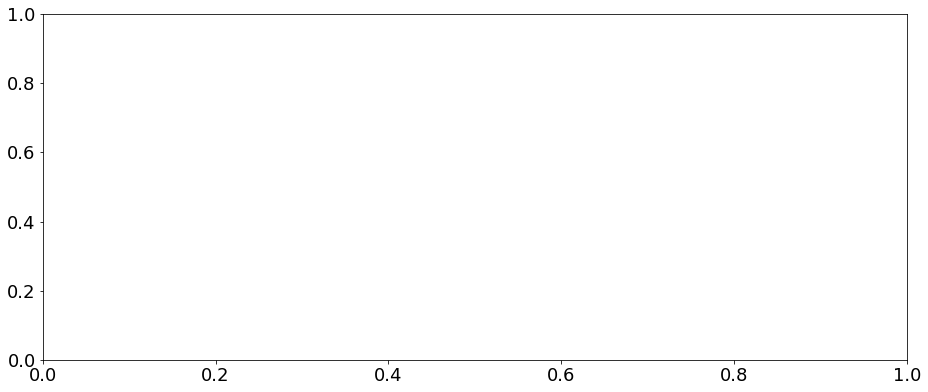

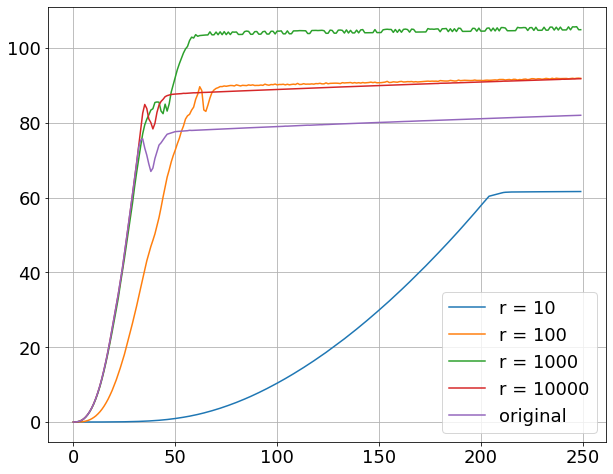

In [41]:

SMALL_SIZE = 18
MEDIUM_SIZE = 25
BIGGER_SIZE = 30

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
# plt.clf()

plt.axes([1, 1, 2, 1.2])
plt.figure(figsize=(10, 8))
plt.plot(mi_group[0], label = "r = 10")
plt.plot(mi_group[1], label = "r = 100")
plt.plot(mi_group[2], label = "r = 1000")
plt.plot(mi_group[3], label = "r = 10000")
plt.plot(mi_group[4], label = "original")
plt.legend()
# plt.plot(mi[3])
plt.grid(True)

In [13]:
# output the midi
v_recons = []
v_weightss = []
for i, z in enumerate(z_quant):
    if i % 100 == 0:
        print(i)
    model.eval()
    v_z = torch.from_numpy(z).float().unsqueeze(0)
    v_measure = torch.zeros((1, seq_len))
    if torch.cuda.is_available():
        v_z = v_z.cuda()
        v_measure = v_measure.cuda()
    with torch.no_grad():
        v_weights, v_samples = model.decoder(v_z, v_measure, False)
        v_recon = torch.argmax(v_weights,-1).detach().cpu().numpy()
        v_recons.append(v_recon)
        v_weightss.append(v_weights.detach().cpu().numpy())
v_recons = np.concatenate(v_recons, axis = 0)
v_weightss = np.concatenate(v_weightss, axis = 0)
print(v_recons.shape)
print(v_weightss.shape)
print(mean_accuracy(torch.from_numpy(v_weightss), torch.from_numpy(z_gd)))

0
100
200
300
400
500
600
700
(742, 48)
(742, 48, 86)
tensor(0.9772)


In [14]:
np.save("bach_recon_1_rate_1000.npy", v_recons)